In [1]:
import sys
sys.path.append("./")

In [2]:
from math import floor
import matplotlib.pyplot as plt

def bucketize(point, bucket_size):
    return bucket_size * floor(point / bucket_size)

def make_histogram(points, bucket_size):
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

In [3]:
import random
from lib.lin_alg_probability import *
from collections import Counter

random.seed(0)

uniform = [200 * random.random() - 100 for _ in range(10000)]

normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

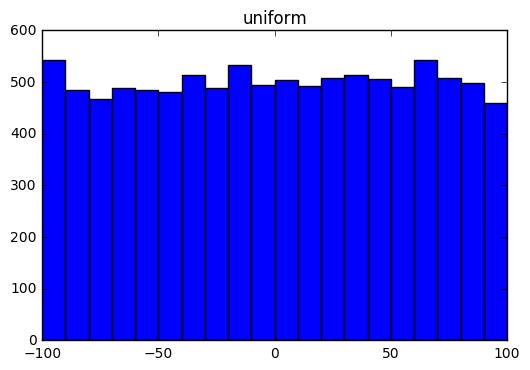

In [4]:
plot_histogram(uniform, 10, "uniform")

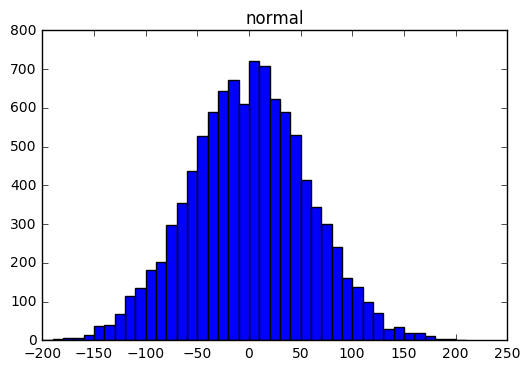

In [5]:
plot_histogram(normal, 10, "normal")

In [6]:
def random_normal():
    return inverse_normal_cdf(random.random())

In [7]:
xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

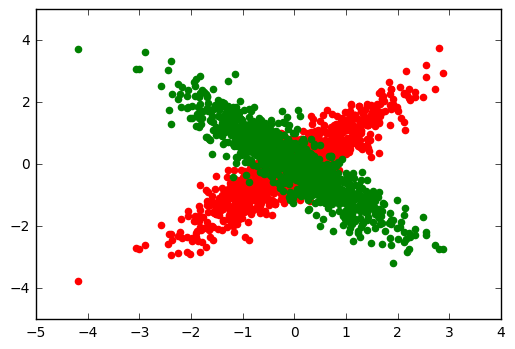

In [8]:
plt.scatter(xs, ys1, color='red', label="ys1")
plt.scatter(xs, ys2, color='green', label="ys2")
plt.show()

In [9]:
from lib.lin_alg_statistics import *

In [10]:
correlation(xs, ys1)

0.900148319269323

In [11]:
correlation(xs, ys2)

-0.8912060545353153

In [12]:
from lib.lin_alg_matrices import *

In [13]:
def correlation_matrix(data):
    _, num_columns = shape(data)
    
    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))
    
    return make_matrix(num_columns, num_columns, matrix_entry)

In [14]:
correlation_matrix([[1,2,3], [4,5,6], [7,8,9]])

[[0.6666666666666666, 0.6666666666666666, 0.6666666666666666],
 [0.6666666666666666, 0.6666666666666666, 0.6666666666666666],
 [0.6666666666666666, 0.6666666666666666, 0.6666666666666666]]

In [15]:
correlation_matrix([[1,5,8], [3,1,7], [9,1,4]])

[[0.6666666666666666, -0.46225016352102405, -0.6666666666666666],
 [-0.4622501635210241, 0.6666666666666665, 0.46225016352102416],
 [-0.6666666666666666, 0.4622501635210241, 0.6666666666666667]]

In [16]:
def make_scatter(data):    
    _, num_columns = shape(data)
    
    fig, ax = plt.subplots(num_columns, num_columns)
    
    for i in range(num_columns):
        for j in range(num_columns):
            if i != j:
                ax[i][j].scatter(get_column(data, j), get_column(data, i))
            else:
                ax[i][j].annotate("series " + str(i), (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
                
            if i < num_columns -1 : 
                ax[i][j].xaxis.set_visible(False)
            
            if j > 0:
                ax[i][j].yaxis.set_visible(False)
                
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
    ax[0][0].set_ylim(ax[0][1].get_ylim())
    
    plt.show()

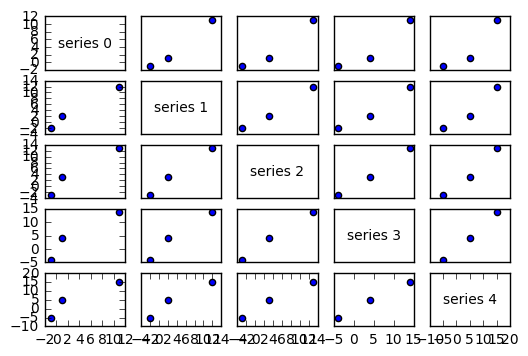

In [17]:
make_scatter([[1,2,3,4,5], [-1,-2,-3,-4,-5], [11,12,13,14,15]])

# Cleaning and Munging

In [75]:
def try_or_none(f):
    def f_or_none(x):
        try:
            return f(x)
        except:
            return None
    return f_or_none

def parse_row(row, parsers):
    return [try_or_none(parser)(value) if parser is not None else None for value, parser in zip(row, parsers)]

def parse_rows_with(reader, parsers):
    for row in reader:
        yield parse_row(row, parsers)

In [63]:
import csv
def csv_read(filename, parsers):
    data = []
    with open(filename, "r") as file:
        reader = csv.reader(file)
        for line in parse_rows_with(reader, parsers):
            data.append(line)
    return data

In [114]:
test_data = csv_read("data/loanf.csv", [str, float, int, int, float, int])
print(test_data[:10])

[['Id', None, None, None, None, None], ['6', 15.31, 670, 36, 4891.67, 6000], ['11', 19.72, 670, 36, 3575.0, 2000], ['12', 14.27, 665, 36, 4250.0, 10625], ['13', 21.67, 670, 60, 14166.67, 28000], ['21', 21.98, 665, 36, 6666.67, 22000], ['23', 17.99, 665, 60, 4100.0, 6500], ['25', 16.82, 670, 60, 4500.0, 4000], ['40', 12.49, 660, 36, 3448.33, 2400], ['41', 17.27, 670, 36, 2500.0, 3200]]


In [104]:
def parse_dict(fieldname, value, parser_dict):
    parser = parser_dict.get(fieldname)
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return None

def parse_dict_row(input, parser_dict):
    return {fieldname: parse_dict(fieldname, value, parser_dict) for fieldname, value in input.items()}

def parse_dict_rows_with(reader, parsers):
    for row in reader:
        yield parse_dict_row(row, parsers)

def csv_dict_read(filename, parser_dict):
    data = []
    with open(filename, "r") as file:
        reader = csv.DictReader(file)
        for line in parse_dict_rows_with(reader, parser_dict):
            data.append(line)
    return data

In [115]:
dict_test_data = csv_dict_read(
    "data/loanf.csv", 
    {"Id": str, "Interest.Rate":float ,"FICO.Score":int,"Loan.Length":int,"Monthly.Income":float,"Loan.Amount": int})
print(dict_test_data[:10])

[{'Monthly.Income': 4891.67, 'Interest.Rate': 15.31, 'Loan.Length': 36, 'FICO.Score': 670, 'Loan.Amount': 6000, 'Id': '6'}, {'Monthly.Income': 3575.0, 'Interest.Rate': 19.72, 'Loan.Length': 36, 'FICO.Score': 670, 'Loan.Amount': 2000, 'Id': '11'}, {'Monthly.Income': 4250.0, 'Interest.Rate': 14.27, 'Loan.Length': 36, 'FICO.Score': 665, 'Loan.Amount': 10625, 'Id': '12'}, {'Monthly.Income': 14166.67, 'Interest.Rate': 21.67, 'Loan.Length': 60, 'FICO.Score': 670, 'Loan.Amount': 28000, 'Id': '13'}, {'Monthly.Income': 6666.67, 'Interest.Rate': 21.98, 'Loan.Length': 36, 'FICO.Score': 665, 'Loan.Amount': 22000, 'Id': '21'}, {'Monthly.Income': 4100.0, 'Interest.Rate': 17.99, 'Loan.Length': 60, 'FICO.Score': 665, 'Loan.Amount': 6500, 'Id': '23'}, {'Monthly.Income': 4500.0, 'Interest.Rate': 16.82, 'Loan.Length': 60, 'FICO.Score': 670, 'Loan.Amount': 4000, 'Id': '25'}, {'Monthly.Income': 3448.33, 'Interest.Rate': 12.49, 'Loan.Length': 36, 'FICO.Score': 660, 'Loan.Amount': 2400, 'Id': '40'}, {'Monthl

In [109]:
from collections import defaultdict

def picker(fieldname):
    return lambda row: row[fieldname]

def pluck(fieldname, rows):
    return map(picker(fieldname), rows)

def group_by(grouper, rows, transform=None):
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
        
    if transform is None:
        return grouped
    else:
        return {key : transform(rows) for key, rows in grouped.items()}

In [118]:
max_loan_by_lentgth = group_by(
    picker('Loan.Length'),
    dict_test_data,
    lambda rows: max(pluck('Loan.Amount', rows))
)
print(max_loan_by_lentgth)

min_loan_by_lentgth = group_by(
    picker('Loan.Length'),
    dict_test_data,
    lambda rows: min(pluck('Loan.Amount', rows))
)
print(min_loan_by_lentgth)

{36: 35000, 60: 35000}
{36: 1000, 60: 2500}


# Rescaling

In [22]:
from lib.lin_alg_matrices import *
from lib.lin_alg_statistics import *

def scale(data_matrix):
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix, j)) for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix, j)) for j in range(num_cols)]
    return means, stdevs

def rescale(data_matrix):
    means, stdevs = scale(data_matrix)
    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]
    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

In [23]:
test_matrix = [
    [1,2,3],
    [4,5,6],
    [7,8,9]
]

In [24]:
scale(test_matrix)

([4.0, 5.0, 6.0], [3.0, 3.0, 3.0])

In [25]:
rescale(test_matrix)

[[-1.0, -1.0, -1.0], [0.0, 0.0, 0.0], [1.0, 1.0, 1.0]]

In [26]:
scale(rescale(test_matrix))

([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])

# Dimensionality Reduction

In [27]:
def de_mean_matrix(A):
    num_rows, num_cols = shape(A)
    column_means, _ = scale(A)
    return make_matrix(num_rows, num_cols, lambda i, j: A[i][j] - column_means[j])

In [28]:
de_mean_matrix(test_matrix)

[[-3.0, -3.0, -3.0], [0.0, 0.0, 0.0], [3.0, 3.0, 3.0]]

In [29]:
from lib.lin_alg_gradient_descent import *
from lib.lin_alg_vectors import *

def direction(w):
    mag = magnitude(w)
    #print([w_i / mag for w_i in w])
    return [w_i / mag for w_i in w]

def directional_variance_i(x_i, w):
    #print(dot(x_i, direction(w)) ** 2)
    return dot(x_i, direction(w)) ** 2

def directional_variance(X, w):
    #print(sum(directional_variance_i(x_i, w) for x_i in X))
    return sum(directional_variance_i(x_i, w) for x_i in X)

def directional_variance_gradient_i(x_i, w):
    projection_length = dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    return vector_sum_hof_reduce(directional_variance_gradient_i(x_i, w) for x_i in X)

def first_principal_component(X):
    guess = [1 for _ in X[0]]
    #print(guess)
    #print(partial(directional_variance, X))
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X),
        partial(directional_variance_gradient, X),
        guess
    )
    #print(unscaled_maximizer)
    return direction(unscaled_maximizer)

In [30]:
first_principal_component(test_matrix)

[0.47975452078456343, 0.5723759124902145, 0.6649973041958654]

In [31]:
def first_principal_component_sgd(X):
    guess = [1 for _ in X[0]]
    #print(guess)
    #print(partial(directional_variance, X))
    unscaled_maximizer = maximize_stochastic(
        lambda x, _, w: directional_variance_i(x,w),
        lambda x, _, w: directional_variance_gradient_i(x,w),
        X,
        [None for _ in X], 
        guess
    )
    #print(unscaled_maximizer)
    return direction(unscaled_maximizer)

In [32]:
first_principal_component_sgd(test_matrix)

[0.5773502691896258, 0.5773502691896258, 0.5773502691896258]

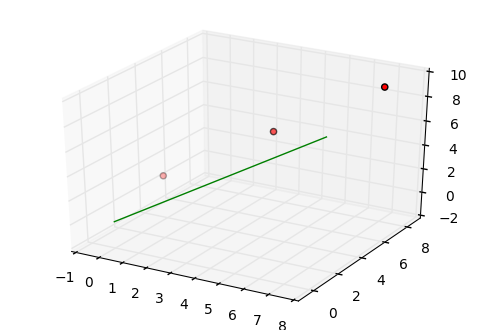

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from lib.lin_alg_matrices import *

fpc = first_principal_component_sgd(test_matrix)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(get_column(test_matrix, 0), get_column(test_matrix, 1), get_column(test_matrix, 2), zdir='z', c= 'red')
ax.plot([0, fpc[0], fpc[0] * 10], [0, fpc[1], fpc[1] * 10], [0, fpc[2], fpc[2] * 10], zdir="z", c='green')
plt.show()

In [49]:
def project(v, w):
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

def remove_projection_from_vector(v, w):
    return vector_subtract(v, project(v, w))

def remove_projection(X, w):
    return [remove_projection_from_vector(x_i, w) for x_i in X]

In [50]:
projected_test_matrix = remove_projection(test_matrix, fpc)
print(projected_test_matrix)

[[-1.0000000000000004, -4.440892098500626e-16, 0.9999999999999996], [-1.0000000000000009, -8.881784197001252e-16, 0.9999999999999991], [-1.0000000000000018, -1.7763568394002505e-15, 0.9999999999999982]]


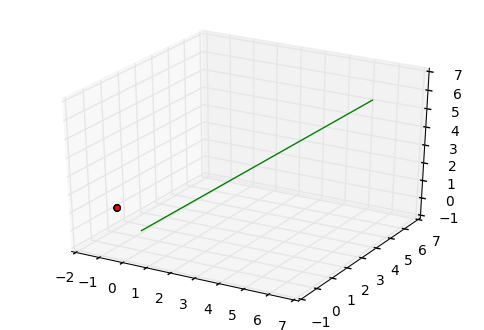

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(get_column(projected_test_matrix, 0), get_column(projected_test_matrix, 1), get_column(projected_test_matrix, 2), zdir='z', c= 'red')
ax.plot([0, fpc[0], fpc[0] * 10], [0, fpc[1], fpc[1] * 10], [0, fpc[2], fpc[2] * 10], zdir="z", c='green')
plt.show()

In [52]:
def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)
        
    return components

def transform_vector(v, components):
    return [dot(v,w) for w in components]

def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]